In [76]:
#os and i/o
import os
import numpy as np
import glob
from os.path import abspath
import csv
import shutil

#scientific computing
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats

#ipython add-ons
from IPython.parallel import Client
from IPython.display import Image
import multiprocessing

##nipype
import nibabel as nib
from nipype.pipeline.engine import Node, MapNode, Workflow
from nipype.interfaces.io import DataGrabber, DataFinder, DataSink
from nipype.interfaces import fsl
from nipype.interfaces.fsl import BET
from nipype.interfaces.freesurfer.preprocess import ReconAll
from nipype.interfaces.freesurfer.utils import MakeAverageSubject
from nipype.interfaces.fsl import ExtractROI
from nipype.interfaces.fsl import Merge
from nipype.interfaces.fsl import TOPUP
from nipype.interfaces.fsl import ApplyTOPUP
from nipype.workflows.fmri.fsl import create_susan_smooth


%matplotlib inline

In [77]:
#preliminary housekeeping
home_dir = '/data/home/iballard/fd/'
subj_file = home_dir + 'subjects_ser.txt'
fix_cmd = '/home/iballard/fix1.06/fix'
sub_list = list(np.loadtxt(subj_file,'string'))
os.chdir(home_dir)

In [97]:
in_tuples = []
for sub in sub_list:
    for exp in ['ser','sim']:
        for run in range(1,4):
            in_tuples.append((sub,exp,str(run)))

In [80]:
#make symbolic links and directory structure that fix expects
for sub in sub_list:
    for exp in ['ser','sim']:
        for run in ['1','2','3']:

            sub_dir = home_dir + 'analysis/' + exp + '_8mm/' + sub + '/preproc/run_' + run + '/'
            
            if os.path.exists(sub_dir):
                melodic_dir = sub_dir + 'melodic/'
                ica_outputs_dir = melodic_dir + 'filtered_func_data.ica/'
                reg_dir = melodic_dir + 'reg/'
                motion_dir = melodic_dir + 'mc/'

                if not os.path.exists(ica_outputs_dir):
                    os.mkdir(ica_outputs_dir)         

                    #move ica outputs from melodic dir to ica outputs dur
                    cmd_str = 'mv ' + melodic_dir + '* ' + ica_outputs_dir
                    os.system(cmd_str)

                    if not os.path.exists(reg_dir):
                        os.mkdir(reg_dir)
                    if not os.path.exists(motion_dir):
                        os.mkdir(motion_dir)

                    old = sub_dir + 'unsmoothed_timeseries.nii.gz'
                    new = melodic_dir + 'filtered_func_data.nii.gz'
                    cmd_str = 'ln -s ' + old + ' ' + new
                    if not os.path.exists(new):
                        os.system(cmd_str)

                    old = sub_dir + 'functional_mask.nii.gz'
                    new = melodic_dir + 'mask.nii.gz'
                    cmd_str = 'ln -s ' + old + ' ' + new
                    if not os.path.exists(new):
                        os.system(cmd_str)

                    old = sub_dir + 'mean_func.nii.gz'
                    new = melodic_dir + 'mean_func.nii.gz'
                    cmd_str = 'ln -s ' + old + ' ' + new
                    if not os.path.exists(new):
                        os.system(cmd_str)

                    old = sub_dir + 'example_func.nii.gz'
                    new = reg_dir + 'example_func.nii.gz'
                    cmd_str = 'ln -s ' + old + ' ' + new
                    if not os.path.exists(new):
                        os.system(cmd_str)

                    old = sub_dir + 'func2anat_flirt.mat'
                    new = reg_dir + 'highres2example_func.mat'
                    cmd_str = 'convert_xfm -omat ' + new + ' -inverse ' + old
                    if not os.path.exists(new):
                        os.system(cmd_str)

                    old = home_dir + 'analysis/workingdir/antswarp/_subject_id_' + sub + '/convertbrain/brain_out.nii.gz'
                    new = reg_dir + 'highres.nii.gz'
                    cmd_str = 'ln -s ' + old + ' ' + new
                    if not os.path.exists(new):
                        os.system(cmd_str)

                    ##deal with motion data
                    data = pd.DataFrame.from_csv(sub_dir + 'realignment_params.csv')
                    data.to_csv(motion_dir + 'prefiltered_func_data_mcf.par',' ',
                                columns = ['rot_x','rot_y','rot_z','trans_x','trans_y','trans_z'],
                               header = False, index = False)
                else:
                    None#print exp + ' ' + sub + ' ' + run


In [96]:
def extract_features(in_tuple):
    sub, exp, run = in_tuple
    
    sub_path = home_dir + 'analysis/' + exp + '_8mm/' + sub + '/preproc/run_' + run + '/melodic'
    fix_dir = sub_path + '/fix'
    
    if os.path.exists(sub_path) and not os.path.exists(fix_dir):
        cmd_str = fix_cmd + ' -f ' + sub_path
        os.system(cmd_str)

In [92]:
pool = multiprocessing.Pool(processes = 30)
pool.map(extract_features,in_tuples)

In [116]:
def classify_features(thresh_tuple):
    sub, exp, run, thresh = thresh_tuple
    sub_path = home_dir + 'analysis/' + exp + '_8mm/' + sub + '/preproc/run_' + run + '/melodic'
    training_file = '/home/iballard/fix1.06/training_files/WhII_MB6.RData'
    thresh_file = sub_path + '/fix4melview_WhII_MB6_thr' + thresh + '.txt'
    
    if not os.path.exists(thresh_file):
        cmd_str = fix_cmd + ' -c ' + sub_path + ' ' + training_file + ' ' + thresh
        print thresh_file
        #os.system(cmd_str)

In [104]:
thresholds = ['5','10','15','20','25','30']
thresh_tuple = []
for sub in sub_list:
    for exp in ['ser','sim']:
        for run in range(1,4):
            for thresh in thresholds:
                thresh_tuple.append((sub,exp,str(run),thresh))

In [117]:
pool = multiprocessing.Pool(processes = 30)
pool.map(classify_features,thresh_tuple)

/data/home/iballard/fd/analysis/ser_8mm/fd_127/preproc/run_3/melodic/fix4melview_WhII_MB6_thr5.txt
/data/home/iballard/fd/analysis/sim_8mm/fd_127/preproc/run_3/melodic/fix4melview_WhII_MB6_thr5.txt
/data/home/iballard/fd/analysis/ser_8mm/fd_136/preproc/run_2/melodic/fix4melview_WhII_MB6_thr5.txt
/data/home/iballard/fd/analysis/ser_8mm/fd_138/preproc/run_2/melodic/fix4melview_WhII_MB6_thr20.txt
/data/home/iballard/fd/analysis/sim_8mm/fd_136/preproc/run_3/melodic/fix4melview_WhII_MB6_thr5.txt
/data/home/iballard/fd/analysis/ser_8mm/fd_137/preproc/run_2/melodic/fix4melview_WhII_MB6_thr5.txt
/data/home/iballard/fd/analysis/ser_8mm/fd_136/preproc/run_2/melodic/fix4melview_WhII_MB6_thr20.txt
/data/home/iballard/fd/analysis/sim_8mm/fd_136/preproc/run_1/melodic/fix4melview_WhII_MB6_thr5.txt
/data/home/iballard/fd/analysis/sim_8mm/fd_138/preproc/run_1/melodic/fix4melview_WhII_MB6_thr5.txt
/data/home/iballard/fd/analysis/sim_8mm/fd_135/preproc/run_3/melodic/fix4melview_WhII_MB6_thr5.txt
/data/ho

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [91]:
#exame what Fix wants to remove for different thresholds
thresholds = ['5','10','15','20','25','30']
bad_pcs = {} #percentage of bad pcs
pcs_list = {} #actual bad PC list
total_pcs = {} #total # of pcs
conds = ['ser','sim']
for thresh in thresholds:
    for cond in conds:
        bad_pcs[(cond,thresh)] = []  

for sub in sub_list:
    for exp in conds:
        for run in ['1','2','3']:
                        
            sub_dir = home_dir + 'analysis/' + exp + '_8mm/' + sub + '/preproc/run_' + run + '/'

            if os.path.exists(sub_dir):
                for thresh in thresholds:
                    id_tuple = (exp,sub,run,thresh)

                    thresh_file = sub_dir + 'melodic/fix4melview_WhII_MB6_thr' + thresh + '.txt'
                    with open(thresh_file) as f:
                        lines = f.readlines()
                        pcs = lines[-1]
                        if pcs.strip('\n') == '[]':
                            pcs_list[id_tuple] = []
                        else:
                            pcs = pcs.strip('[')[:-1].strip(']').strip('\n').split(',')
                            pcs_list[id_tuple] = map(int,pcs)
                        
                        total_pcs[id_tuple] = float(lines[-2].split(',')[0])

                        perc_bad_pcs = [len(pcs_list[id_tuple])/total_pcs[id_tuple]]
                        bad_pcs[(exp,thresh)] = np.hstack([bad_pcs[(exp,thresh)]
                                                  ,perc_bad_pcs])
                                  
            else:
                perc_bad_pcs = np.nan
                for thresh in thresholds:
                    bad_pcs[(exp,thresh)] = np.hstack([bad_pcs[(exp,thresh)]
                                              ,perc_bad_pcs])


IOError: [Errno 2] No such file or directory: '/data/home/iballard/fd/analysis/ser_8mm/fd_135/preproc/run_2/melodic/fix4melview_WhII_MB6_thr5.txt'

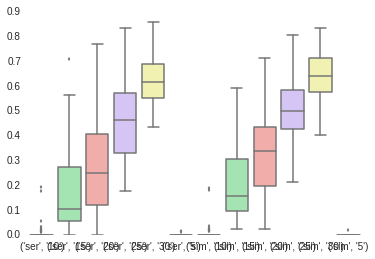

In [167]:
bad_pcs = pd.DataFrame(bad_pcs)
sns.boxplot(bad_pcs,color = 'pastel')

In [175]:
##compute percentage of total variance

#initialize bad pc dictionary
bad_pc_total_variance = {}
for thresh in thresholds:
    for cond in conds:
        bad_pc_total_variance[(cond,thresh)] = []  

for sub in sub_list:
    for exp in conds:
        for run in ['1','2','3']:
            sub_dir = home_dir + 'analysis/' + exp + '_8mm/' + sub + '/preproc/run_' + run + '/'

            if os.path.exists(sub_dir):
                id_tuple = (exp,sub,run,thresh)
                #get list of how much variance is explained by each ic from the report file
                ic_variance = []
                for ic in range(1,int(total_pcs[id_tuple]) + 1):
                    ic_file = sub_dir + 'melodic/filtered_func_data.ica/report/IC_' + str(ic) + '.html'
                    with open(ic_file) as f:
                        html_str = f.readlines()
                        html_str = ','.join(html_str)
                        index = html_str.find('% of total variance') #can also look at explained variance
                        ic_variance.append(float(html_str[index - 5:index-1]))
                        
                #compute total variance explained by bad ics for each threshold level
                for thresh in thresholds:
                    id_tuple = (exp,sub,run,thresh)

                    indices = [i - 1 for i in pcs_list[id_tuple]] #convert to indices (indexing starts at 1 here)
                    bad_ic_variance = [ic_variance[i] for i in indices]
                    bad_ic_variance = np.sum(bad_ic_variance) 
                    bad_pc_total_variance[(exp,thresh)] = np.hstack([bad_pc_total_variance[(exp,thresh)]
                                                                     ,bad_ic_variance])
            else:
                bad_ic_variance = np.nan
                for thresh in thresholds:
                    bad_pc_total_variance[(exp,thresh)] = np.hstack([bad_pc_total_variance[(exp,thresh)]
                                                                     ,bad_ic_variance])
                


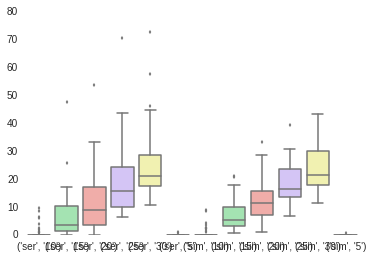

In [176]:
bad_pc_total_variance = pd.DataFrame(bad_pc_total_variance)
sns.boxplot(bad_pc_total_variance,color = 'pastel')

In [18]:
##project out the bad components
def clean_data(in_tuple):
    threshold = '20'
    sub = in_tuple[0]
    exp = in_tuple[1]
    run = str(in_tuple[2])
    
    sub_path = home_dir + 'analysis/' + exp + '_8mm/' + sub + '/preproc/run_' + run + '/melodic'

    thresh_file = sub_path +'/fix4melview_WhII_MB6_thr' + threshold + '.txt'
    cmd_str = fix_cmd + ' -a ' + thresh_file 
    
    new_file = sub_path + '/filtered_func_data_clean.nii.gz'

    if not os.path.exists(new_file):
        os.system(cmd_str)
        

In [19]:
pool = multiprocessing.Pool(processes = 16)
pool.map(clean_data,in_tuples)

/home/iballard/fix1.06/fix -a /data/home/iballard/fd/analysis/sim_8mm/fd_127/preproc/run_3/melodic/fix4melview_WhII_MB6_thr20.txt
/home/iballard/fix1.06/fix -a /data/home/iballard/fd/analysis/ser_8mm/fd_127/preproc/run_3/melodic/fix4melview_WhII_MB6_thr20.txt
/home/iballard/fix1.06/fix -a /data/home/iballard/fd/analysis/sim_8mm/fd_133/preproc/run_3/melodic/fix4melview_WhII_MB6_thr20.txt


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [73]:
def smooth_cleaned_data(in_tuple):
    sub = in_tuple[0]
    exp = in_tuple[1]
    run = str(in_tuple[2])
    
    sub_path = home_dir + 'analysis/' + exp + '_8mm/' + sub + '/preproc/run_' + run
    smooth_dir = 'smoothed' + run + exp + sub
    if not os.path.exists(abspath('smoothed/' + smooth_dir)): #if not already run
        #set up workflow
        wf = Workflow(name = 'smooth')
        wf.basedir = abspath('fd/data/')
        susan = create_susan_smooth()
        susan.inputs.inputnode.fwhm = 8
        susan.inputs.inputnode.in_files = sub_path + '/melodic/filtered_func_data_clean.nii.gz'
        susan.inputs.inputnode.mask_file = sub_path + '/functional_mask.nii.gz'

        ##set up Data Sink
        sinker = Node(DataSink(), name = 'sinker')
        sinker.inputs.base_directory = abspath('smoothed')
        wf.connect(susan,'outputnode.smoothed_files',sinker,smooth_dir)
        wf.run()

In [74]:
pool = multiprocessing.Pool(processes = 12)
# pool.map(smooth_cleaned_data,in_tuples)

In [75]:
#rearrange directory structure to trick lyman into thinking cleaned data is its own
for in_tuple in in_tuples:
    sub = in_tuple[0]
    exp = in_tuple[1]
    run = str(in_tuple[2])
    sub_path = home_dir + 'analysis/' + exp + '_8mm/' + sub + '/preproc/run_' + run

    if os.path.exists(sub_path):
        smooth_clean = home_dir + '/smoothed/smoothed' + run + exp + sub + '/_smooth0/' + \
        'filtered_func_data_clean_smooth.nii.gz'

        new_dir = sub_path + '/uncleaned_data'
        if not os.path.exists(new_dir):
            os.mkdir(new_dir)
        
        #move old lyman files inside new_dir if they arent there already
        old_smooth = sub_path + '/smoothed_timeseries.nii.gz'
        old_unsmoothed = sub_path + '/unsmoothed_timeseries.nii.gz'
        if not os.path.exists(new_dir + '/smoothed_timeseries.nii.gz'):
            shutil.move(old_smooth,new_dir)
        if not os.path.exists(new_dir + '/unsmoothed_timeseries.nii.gz'):
            shutil.move(old_unsmoothed,new_dir)
        
        #move cleaned and smoothed data
        if os.path.exists(smooth_clean) and not os.path.exists(old_smooth):
            os.rename(smooth_clean,old_smooth)
        
        #create a symbolic link to cleaned and unsmoothed data
        if not os.path.exists(old_unsmoothed):
            cmd_str = 'ln -s ' + sub_path + '/melodic/filtered_func_data_clean.nii.gz ' + \
            old_unsmoothed
            os.system(cmd_str)

In [38]:
##create an archive of lyman directories
for in_tuple in in_tuples:
    sub = in_tuple[0]
    exp = in_tuple[1]
    run = str(in_tuple[2])
    
    sub_path = home_dir + 'analysis/' + exp + '_8mm/' + sub +'/'

    if os.path.exists(sub_path):

        archive_dir = sub_path + 'uncleaned'
        if not os.path.exists(archive_dir):
            os.mkdir(archive_dir)

        dir_contents = glob.glob(sub_path + '*')
        dir_contents = [f for f in dir_contents if f.split('/')[-1:][0] not in ['preproc','uncleaned']]

        for f in dir_contents:
            if os.path.exists(f):
                shutil.move(f,archive_dir)